### Desigualdades no Brasil

##### O Aquecimento Global é sentido igualmente por habitantes de uma mesma metrópole?
Pesquisa inicial buscando observar possíveis diferenças entre os efeitos e causas aquecimento global em diferentes bairros do Rio para avaliar se há desigualdade no fenômeno global do aquecimento global em uma mesma metrópole.  


#### Descrição

##### Foco
     - Meio Ambiente

##### Hipóteses de Pesquisa
- Espera-se encontrar diferenças nos níveis de temperatura em diferentes bairros da cidade
- Também se espera encontrar diferentes níveis de umidade, relacionados com a arborização dos bairros. Para bairros com maior arborização se espera maiores níveis de umidade
- Ao observar indicadores de qualidade do ar é pressuposto encontrar maior qualidade em bairros com maior arborização e maior IPS
- Através destes dados se busca analisar a suspeita de desigualdade na percepção do aquecimento global em diferentes bairros de uma mesma cidade

##### Questionamentos a serem respondidos
- Pode-se dizer que percepção das pessoas de uma mesma cidade sobre o aquecimento global é a mesma?
- O nível de arborização em cada bairro demonstra efeitos nas diferentes características do ambiente?
- É possível observar desigualdade na infraestrutura de resfriação (como arborização) em bairros com diferentes níveis de progresso social?
     - Isso poderia indicar uma abordagem ambiental desigual relacionada à diferentes bairros?

##### Datasets utilizados
     https://basedosdados.org/dataset/br-rj-rio-de-janeiro-ipp-ips?bdm_table=dimensoes_componentes
     https://www.data.rio/datasets/PCRJ::estações-de-monitoramento-da-qualidade-do-ar-monitorar/explore?location=-22.938143%2C-43.367757%2C11.45

#### Contextualização

O nível de arborização ...


#### Análise

In [48]:
import pandas                as pd
import matplotlib.pyplot     as plt
import re

In [67]:
# índice de progresso
df_ip = pd.read_csv('./data/dimensoes_componentes.csv', index_col = 0).reset_index()
# estação metereológica (qualidade do ar)
df_q = pd.read_csv('./data/qualidade_do_ar.csv', index_col = 0).reset_index()

In [68]:
regions = df_ip['regiao_administrativa'].unique()

df_ip = df_ip[df_ip['ano'] == 2020] # get most recent values

l_df = df_ip.nlargest(10, ['ips_geral'])['regiao_administrativa'] # df
largest = [l_df[key] for key in l_df.keys()] # array with district names

s_df = df_ip.nsmallest(10, ['ips_geral'])['regiao_administrativa'] # df
smallest = [s_df[key] for key in s_df.keys()] # array with district names

# 10 highest and 10 lowest
regions20 = largest + smallest 

regions_of_interest = [
    'Bangu', 'São Cristovão', 'Copacabana', 'Iraja',  'Tijuca'
    ]

df_ip = df_ip[ df_ip['regiao_administrativa'].isin(regions_of_interest) ]
df_ip = df_ip[['regiao_administrativa', 'ips_geral']]


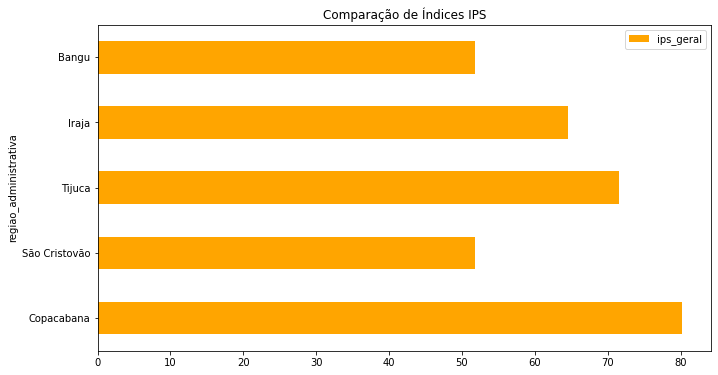

In [69]:
df_ip = df_ip.reset_index(drop=True)
df_ip = df_ip.set_index('regiao_administrativa')

df_ip.plot(kind="barh", title="Comparação de Índices IPS", figsize=(11,6), color="orange")

plt.show()


In [5]:
s_names = [
    'Bangu',         'Campo Grande', 'Centro', 
    'Copacabana',    'Irajá', 'Pedra de Guaratiba', 
    'São Cristóvão', 'Tijuca'
    ]

# monitored params from API website description
stations = [ 
    { "code": "CA",     "name": "Centro",             "air_params": ["O3", "CO", "PM10"] },
    { "code": "AV",     "name": "Copacabana",         "air_params": ["O3", "CO", "PM10", "SO2"] },
    { "code": "SC",     "name": "São Cristóvão",      "air_params": ["O3", "CO", "PM10", "SO2"] },
    { "code": "SP",     "name": "Tijuca",             "air_params": ["O3", "CO", "PM10", "SO2", "NOx"] },
    { "code": "IR" ,    "name": "Irajá",              "air_params": ["O3", "CO", "PM10", "SO2", "NOx", "HC", "PM2.5"] },
    { "code": "BG" ,    "name": "Bangu",              "air_params": ["O3", "CO", "PM10", "SO2", "NOx", "HC"] },
    { "code": "CG" ,    "name": "Campo Grande",       "air_params": ["O3", "CO", "PM10", "SO2", "NOx", "HC"] },
    { "code": "PG" ,    "name": "Pedra de Guaratiba", "air_params": ["O3", "PM10"] }
]

centro       = df_q[df_q['Estação'].str.contains('CA') ]
copa         = df_q[df_q['Estação'].str.contains('AV') ] ###
sao_crist    = df_q[df_q['Estação'].str.contains('SC') ] ##
tijuca       = df_q[df_q['Estação'].str.contains('SP') ] ##
iraja        = df_q[df_q['Estação'].str.contains('IR') ] ### 
bangu        = df_q[df_q['Estação'].str.contains('BG') ] ##
campo_grande = df_q[df_q['Estação'].str.contains('CG') ]
pedra_guarat = df_q[df_q['Estação'].str.contains('PG') ] 

In [6]:
def getTime(date_time):
    r = '[0-9]{2}:[0-9]{2}'
    time = re.search(r, date_time)

    return str(time.group(0))
    
def getDate(date_time):
    r = '[0-9]{4}[\/][0-9]{2}[\/][0-9]{2}'
    date = re.search(r,date_time)

    return str(date.group(0))

# adjust so they end on the same time
def adjustDateTime(df, date_time):
    
    # beggining index
    idx_start = df.index.values[0]
    
    # last value as default
    idx_end = df.index.values[-1]


    try: # get index for same data value
        idx_end = df['1Data'].where(df['1Data'].values == date_time).dropna().index[0]
    except: # exception for tijuca's missing value
        idx_end = df['1Data'].where(df['1Data'].values == '2020/10/29 08:30:00+00').dropna().index[0]
    
    # stop after last date_time 
    return df.truncate(before=idx_start, after=idx_end)

# create columns for date and time
def setDateTime(df):
    df['time'] = '-'
    df['date'] = '-'

    for index, row in df.iterrows():
        df['time'][index] = getTime(row['1Data'])
        df['date'][index] = getDate(row['1Data'])

    return df

In [131]:
# date to adjust the others
date_time = copa.tail(1)['1Data'].iloc[0]

sc = adjustDateTime(sao_crist, date_time)                         # stoped at 2021/03/31
sao_crist_24h = sc[['1Data', 'Temp', 'O3', 'PM10', 'UR']].tail(24)
setDateTime(sao_crist_24h)

# reference: last measurement
copa_24h      = copa[['1Data', 'Temp', 'O3', 'PM10', 'UR']].tail(24)     # stops at 2020/10/29
setDateTime(copa_24h)

t = adjustDateTime(tijuca, date_time)                             # stoped at 2021/03/31
tijuca_24h    = t[['1Data', 'Temp', 'O3', 'PM10', 'UR']].tail(24)    
setDateTime(tijuca_24h)

i = adjustDateTime(iraja, date_time)                              # stoped at 2021/03/31
iraja_24h     = i[['1Data', 'Temp', 'O3', 'PM10', 'UR']].tail(24)     
setDateTime(iraja_24h)

b = adjustDateTime(bangu, date_time)                           # stoped at 2021/03/01
bangu_24h     = b[['1Data', 'Temp', 'O3', 'PM10', 'UR']].tail(24)     # stoped at 2021/03/01
setDateTime(bangu_24h)

C:\Users\keith\AppData\Local\Temp/ipykernel_10188/2749256803.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'][index] = getTime(row['1Data'])
C:\Users\keith\AppData\Local\Temp/ipykernel_10188/2749256803.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'][index] = getDate(row['1Data'])
C:\Users\keith\AppData\Local\Temp/ipykernel_10188/2749256803.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'][in

,1Data,Temp,O3,PM10,UR,time,date
619009,2020/10/28 10:30:00+00,37.90,116.24,51.0,31.75,10:30,2020/10/28
619010,2020/10/28 11:30:00+00,38.87,138.46,54.0,27.90,11:30,2020/10/28
619011,2020/10/28 12:30:00+00,39.92,140.60,30.0,26.38,12:30,2020/10/28
619012,2020/10/28 13:30:00+00,39.92,137.98,42.0,23.90,13:30,2020/10/28
619013,2020/10/28 14:30:00+00,39.68,132.82,49.0,20.80,14:30,2020/10/28
619014,2020/10/28 15:30:00+00,39.05,127.49,27.0,19.25,15:30,2020/10/28
619015,2020/10/28 16:30:00+00,37.53,127.65,21.0,19.57,16:30,2020/10/28
619016,2020/10/28 17:30:00+00,35.52,118.37,29.0,21.98,17:30,2020/10/28
619017,2020/10/28 18:30:00+00,33.10,104.03,45.0,25.60,18:30,2020/10/28
619018,2020/10/28 19:30:00+00,31.53,79.46,41.0,32.72,19:30,2020/10/28


In [132]:
# Plotting only for specific day in the middle of the 24h range to check time changes
sao_crist_plot = sao_crist_24h[ sao_crist_24h['date'] == '2020/10/28' ].dropna()
copa_plot      = copa_24h[ copa_24h['date'] == '2020/10/28' ].dropna()
tijuca_plot    = tijuca_24h[ tijuca_24h['date'] == '2020/10/28' ].dropna()
iraja_plot     = iraja_24h[ iraja_24h['date'] == '2020/10/28' ].dropna()
bangu_plot     = bangu_24h[ bangu_24h['date'] == '2020/10/28' ].dropna()

<AxesSubplot:xlabel='time'>

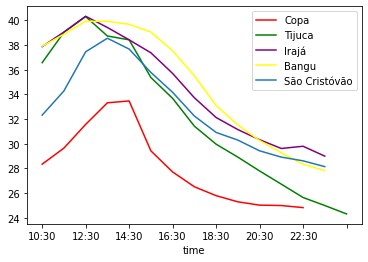

In [133]:
# Temperatura
copa_plot['Temp']      = copa_plot['Temp'].astype(float)
tijuca_plot['Temp']    = tijuca_plot['Temp'].astype(float)
iraja_plot['Temp']     = iraja_plot['Temp'].astype(float)
bangu_plot['Temp']     = bangu_plot['Temp'].astype(float)
sao_crist_plot['Temp'] = sao_crist_plot['Temp'].astype(float)

ax = copa_plot.plot(x='time', y='Temp', label='Copa', color='Red')
tijuca_plot.plot(x='time', y='Temp', label='Tijuca', ax=ax, color='Green')
iraja_plot.plot(x='time', y='Temp', label='Irajá', ax=ax, color='Purple')
bangu_plot.plot(x='time', y='Temp', label='Bangu', ax=ax, color='Yellow')
sao_crist_plot.plot(x='time', y='Temp', label='São Cristóvão', ax=ax)


<AxesSubplot:xlabel='time', ylabel='O3'>

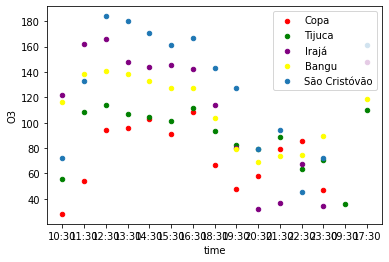

In [139]:
# O3
ax = copa_plot.plot(kind='scatter', y='O3', x='time', label='Copa', color='Red')
tijuca_plot.plot(kind='scatter', y='O3', x='time', label='Tijuca', ax=ax, color='Green')
iraja_plot.plot(kind='scatter', y='O3', x='time', label='Irajá', ax=ax, color='Purple')
bangu_plot.plot(kind='scatter', y='O3', x='time', label='Bangu', ax=ax, color='Yellow')
sao_crist_plot.plot(kind='scatter', y='O3', x='time', label='São Cristóvão', ax=ax)


<AxesSubplot:xlabel='time', ylabel='PM10'>

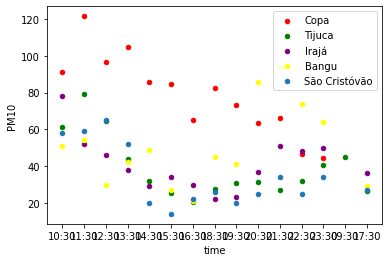

In [135]:
# PM10
ax = copa_plot.plot(kind='scatter', y='PM10', x='time', label='Copa', color='Red')
tijuca_plot.plot(kind='scatter', y='PM10', x='time', label='Tijuca', ax=ax, color='Green')
iraja_plot.plot(kind='scatter', y='PM10', x='time', label='Irajá', ax=ax, color='Purple')
bangu_plot.plot(kind='scatter', y='PM10', x='time', label='Bangu', ax=ax, color='Yellow')
sao_crist_plot.plot(kind='scatter', y='PM10', x='time', label='São Cristóvão', ax=ax)

<AxesSubplot:xlabel='time'>

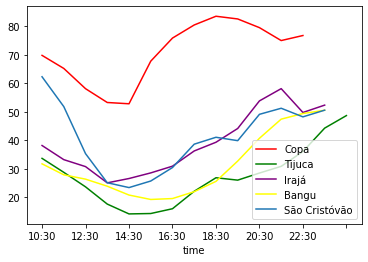

In [138]:
# Umidade
ax = copa_plot.plot(y='UR', x='time', label='Copa', color='Red')
tijuca_plot.plot(y='UR', x='time', label='Tijuca', ax=ax, color='Green')
iraja_plot.plot(y='UR', x='time', label='Irajá', ax=ax, color='Purple')
bangu_plot.plot(y='UR', x='time', label='Bangu', ax=ax, color='Yellow')
sao_crist_plot.plot(y='UR', x='time', label='São Cristóvão', ax=ax)
